#Q-Learning for Blackjack

This is the actual lab file. However, we strongly recommend having a look at the Blackjack playground to understand the environment before beginning.
First we load the required packages. (Note that the provided gym environment and plotting functionalities are automatically downloaded - follow the link if you want to see the code).

In [1]:
try:
    # Check if notebook is running in Google Colab
    #import google.colab
    # Get additional files from Github
    #!wget https://raw.githubusercontent.com/volkerkrueger/RL-Lab/master/blackjack.py
    #!wget https://raw.githubusercontent.com/volkerkrueger/RL-Lab/master/plotting.py
    # Install additional dependencies
    #!pip install gym
    #!apt-get install python3-opengl -y
    # if you get an error here, run the following line instead
    #!apt-get install python-opengl -y
    import gym
    import matplotlib
    import numpy as np
    import sys
    import time
    from blackjack import BlackjackEnv
    from collections import defaultdict
    import plotting
    matplotlib.style.use('ggplot')
    print("sucess")
except:
    pass
    %matplotlib inline

#from collections import defaultdict

#from blackjack import BlackjackEnv

sucess


In [2]:
env = BlackjackEnv()

First we implement the epsilon greed policy, given the current policy matrix Q and an $\varepsilon$.

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        probabilities = np.ones(nA)*(epsilon)/(nA) # set all actions to default epsilon value
        q = Q[observation] # retrieve Q for current observation list[int]
        max_probability_index = np.argmax(q) #retrieve index of highest action-value
        probabilities[max_probability_index] += (1-epsilon) # will have probablity (1-epsilon)+epsilon/nA
        return probabilities
    
    return policy_fn

# The training loop

Next we train our agent using Q-learning. Here you need to implement the full training loop - iteratively generating new episodes and using them to learn your policy function Q. Note that we want $ɛ_k \rightarrow 0$ as $k\rightarrow \infty$.

In [51]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.

    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The policy we're following
    

    # Implement this!
    nA = env.action_space.n
    n = 1000
    dividers = np.geomspace(1, 10000, num=n, endpoint=True)
    env = BlackjackEnv()
    idx = -1
    for episode in range(num_episodes):
        if episode % (num_episodes/n) == 0:
            idx += 1
        
        policy = make_epsilon_greedy_policy(Q, epsilon/dividers[idx] , env.action_space.n)
        done = 0
        observation = env.reset()
        memory = []
        for limit in range(100):
            #score, dealer_score, usable_ace = observation
            probabilities = policy(observation)
            action = np.random.choice(np.arange(nA), p=probabilities) #effectively produces a 0 or a 1 with probabilities 1-epsilon or epsilon respectively
            next_observation, reward, done, _ = env.step(action)
            memory.append((observation, action, reward))
            if done:
                break
            observation = next_observation

        G = 0 # Holds the total reward for the series of the action
        visited = set()
        for (observation, action, reward) in memory:
            G = discount_factor*G + reward # iteratively discounts the oldest actions, need to be outside of first visit to keep continuity
            if observation not in visited:
                returns_sum[observation] += G # adds the reward to the exploration dictionary
                returns_count[observation] +=  1 # keeps track of total updates for each state
                Q[observation] = returns_sum[observation]/returns_count[observation]
                visited.add(observation)
    return Q, policy

In [64]:
start = time.process_time()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=250000, epsilon=0.20)

end = time.process_time()
print("\n",end - start,"s")


 12.938934000000017 s


# Run and test

Finally, we run our training and plot the state reward surface. We recommend playing around with num_episodes, epsilon as well as the epsilon decay strategy.

Increasing epsilon prevents model convergense. With epsilons above 0.5 the model does not converge at all. With an epsilon of zero, the model does converge, but it increases with a small epsilon. 

When I implement an exponentially dynamic epsilon I can make the model converge with initial epsilon values of even 50%. The model still performs best with lower epsilon values. The effect becomes negligable when initial epsilon is below 10%. 

With number of episode set to 250.000, initial epsilon of 20% and an exponentially decreasing epsilon every 250th episode i get top values around:

- for no usable ace
- - for usable ace

I tried increasing the number of episode to 500.000 but that did not impact performance.

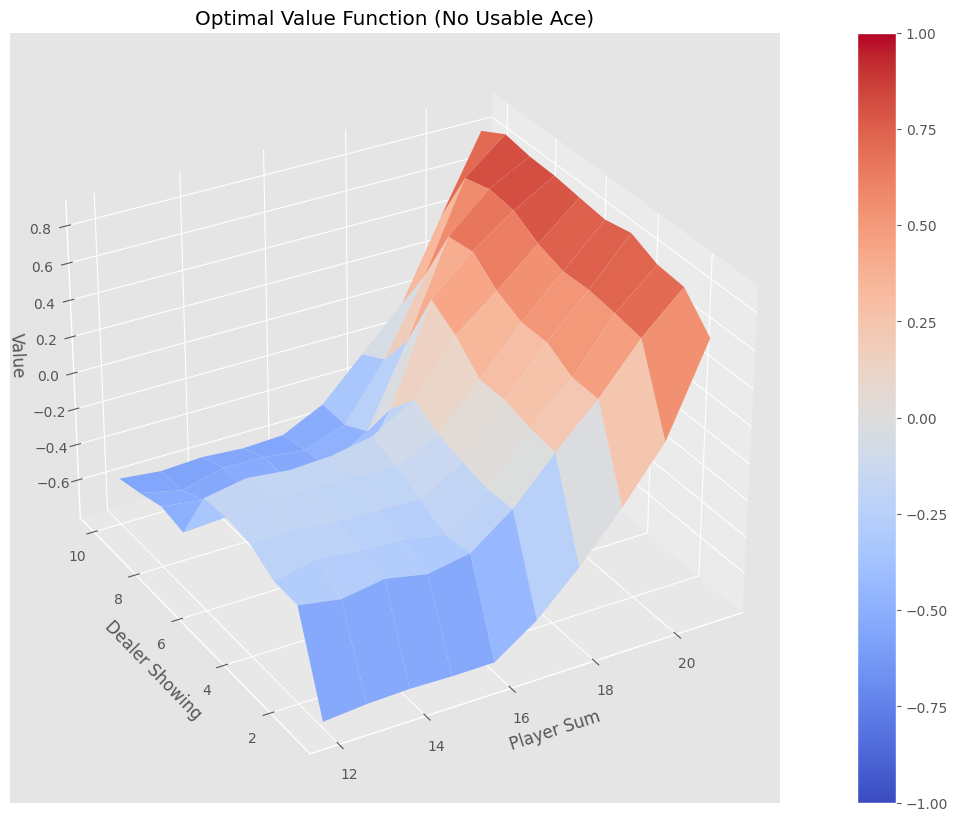

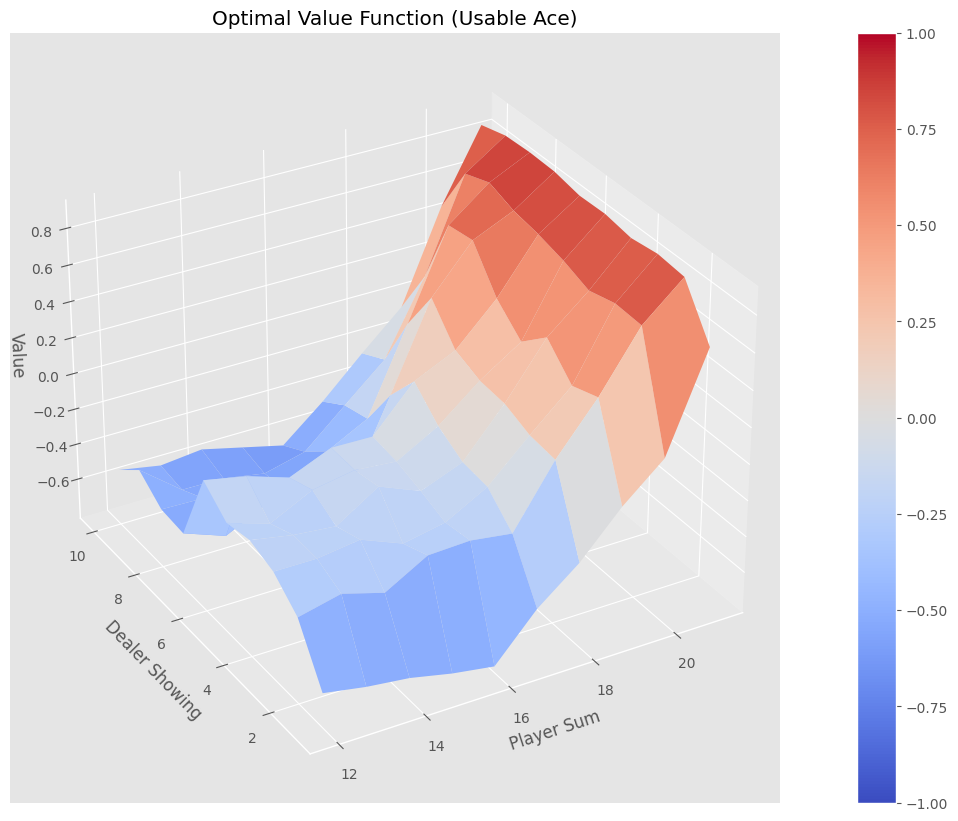

In [65]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")